In [1]:
import os, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================================================
# 1️⃣ Setup
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

🚀 Using device: cuda


In [3]:
pip install lmdb

Note: you may need to restart the kernel to use updated packages.


In [3]:
DATA_PATH = r"C:\Users\dilip\datasets\LSUN"   # ← change this to your LSUN or image folder path
SAVE_DIR = "./gan_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
from torchvision.datasets import CIFAR10
dataset = CIFAR10(root="./data", download=True, transform=transform)

loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
print(f"✅ Loaded {len(dataset)} images for training")

100%|██████████| 170M/170M [02:12<00:00, 1.29MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
✅ Loaded 50000 images for training


Epoch 1/10: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]


Epoch [1/10]  Loss_D: 0.5774  Loss_G: 2.5054


Epoch 2/10: 100%|██████████| 391/391 [00:34<00:00, 11.17it/s]


Epoch [2/10]  Loss_D: 0.4611  Loss_G: 3.9635


Epoch 3/10: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Epoch [3/10]  Loss_D: 0.3118  Loss_G: 3.2639


Epoch 4/10: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]


Epoch [4/10]  Loss_D: 0.4068  Loss_G: 2.9177


Epoch 5/10: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Epoch [5/10]  Loss_D: 0.1176  Loss_G: 4.5901


Epoch 6/10: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Epoch [6/10]  Loss_D: 0.1233  Loss_G: 3.2137


Epoch 7/10: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Epoch [7/10]  Loss_D: 0.0099  Loss_G: 6.2495


Epoch 8/10: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]


Epoch [8/10]  Loss_D: 0.2116  Loss_G: 5.1409


Epoch 9/10: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Epoch [9/10]  Loss_D: 0.0058  Loss_G: 5.2631


Epoch 10/10: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Epoch [10/10]  Loss_D: 0.2870  Loss_G: 6.2646
✅ Training complete! Check gan_outputs/ for generated samples.


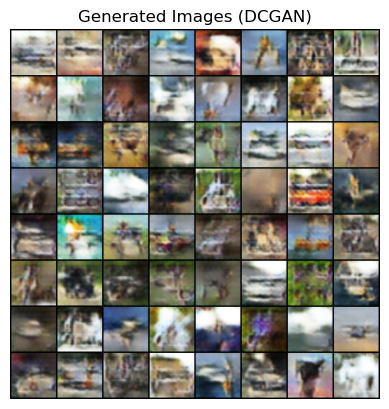

The system cannot find the path specified.


ModuleNotFoundError: No module named 'cleanfid'

In [4]:
latent_dim = 100
ngf, ndf = 64, 64

# --- Generator ---
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x).view(-1)

G, D = Generator().to(device), Discriminator().to(device)
criterion = nn.BCELoss()
optD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# ================================================================
# 4️⃣ Training Loop
# ================================================================
epochs = 10
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

for epoch in range(1, epochs+1):
    for imgs, _ in tqdm(loader, desc=f"Epoch {epoch}/{epochs}"):
        imgs = imgs.to(device)
        bsize = imgs.size(0)

        # 1. Train Discriminator
        D.zero_grad()
        real_label = torch.ones(bsize, device=device)
        fake_label = torch.zeros(bsize, device=device)

        out_real = D(imgs)
        loss_real = criterion(out_real, real_label)

        noise = torch.randn(bsize, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        out_fake = D(fake_imgs.detach())
        loss_fake = criterion(out_fake, fake_label)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()

        # 2. Train Generator
        G.zero_grad()
        out_fake = D(fake_imgs)
        loss_G = criterion(out_fake, real_label)
        loss_G.backward()
        optG.step()

    print(f"Epoch [{epoch}/{epochs}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}")

    # Save generated sample grid
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        utils.save_image((fake+1)/2, f"{SAVE_DIR}/epoch{epoch}_samples.png", nrow=8)
print("✅ Training complete! Check gan_outputs/ for generated samples.")

# ================================================================
# 5️⃣ Visualize generated samples
# ================================================================
import matplotlib.image as mpimg
img = mpimg.imread(f"{SAVE_DIR}/epoch{epochs}_samples.png")
plt.imshow(img)
plt.axis("off")
plt.title("Generated Images (DCGAN)")
plt.show()

# ================================================================
# 6️⃣ Compute FID Score
# ================================================================
!pip install clean-fid > /dev/null

from cleanfid import fid
fid_score = fid.compute_fid(fdir1=DATA_PATH, fdir2=SAVE_DIR)
print(f"📊 Fréchet Inception Distance (FID): {fid_score:.2f}")